In [1]:
import polars as pl, requests, os, zipfile

class StopExecution(Exception):
    def _render_traceback_(self):
        return []

requests=requests.Session()

requests.headers.update({'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'})

# Get taxonomy data (specifically, the mapping between common name and scientific name)
# Another list (https://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/complete/docs/speclist.txt) was also available, but was not in a machine-readable format

csv_file = "eBird-Clements-v2024-integrated-checklist-October-2024-rev.csv"

if not os.path.exists(csv_file):
    with open(csv_file, "wb") as f:
        f.write(requests.get(f"https://www.birds.cornell.edu/clementschecklist/wp-content/uploads/2024/10/{csv_file}").content)

taxon = pl.read_csv(csv_file, columns=["scientific name", "English name"])

# Get observation data
base_name = "0001113-241107131044228"
if not os.path.exists(base_name+".zip"):
    with open(base_name+".zip","wb") as f:
        f.write(requests.get(f"https://api.gbif.org/v1/occurrence/download/request/{base_name}.zip").content)

if not os.path.exists(base_name+".csv"):
    with zipfile.ZipFile(base_name+".zip") as f:
        f.extractall()

df = pl.read_csv(base_name+".csv", columns=["species", "decimalLatitude", "decimalLongitude"], separator="\t")

df.drop_nulls(subset=["species"]) # Remove all rows with a NULL species, since we obviously can't use that

# Remove all hybrid species 
df = df.filter(~pl.col("species").str.contains(r"(.*) x (.*)"))

name_col="COMMON NAME"
lat_col="LATITUDE"
long_col="LONGITUDE"
habitat_col="HABITAT"

# Retrieve the common name for each bird
df = df.rename({"species": "scientific name"})
df = df.join(taxon, on="scientific name")
df = df.drop(["scientific name"])
df = df.rename({"decimalLatitude": lat_col, "decimalLongitude": long_col, "English name": name_col})
display(df)


LATITUDE,LONGITUDE,COMMON NAME
f64,f64,str
40.803162,-73.948906,"""Downy Woodpecker"""
40.621226,-73.62212,"""Tree Swallow"""
43.056908,-77.011726,"""Red-breasted Nuthatch"""
40.659751,-73.966651,"""Wood Duck"""
40.746058,-74.000717,"""House Finch"""
…,…,…
41.857278,-73.98188,"""Red-shouldered Hawk"""
42.587273,-73.912025,"""Canada Goose"""
42.789097,-78.851825,"""Black-throated Green Warbler"""


In [2]:
# Get preferred habitats
habitats_file = "habitats.csv"
from alive_progress import alive_bar, config_handler

config_handler.set_global(force_tty=True, enrich_print = False)

if not os.path.exists(habitats_file):
    from lxml import html
    
    habitats={name_col: [], habitat_col: []}


    birds = df.select(name_col).unique()

    with alive_bar(len(birds)) as bar:
        for bird in birds.iter_rows():
            bird = bird[0]
            old_bird = bird
            bird=bird.replace(" ","_").replace("'","")
        
            doc = html.fromstring(requests.get(f"https://www.allaboutbirds.org/guide/{bird}").text)
            habitat = doc.xpath("//*[text()='Habitat']/following-sibling::node()") #Or use getnext
        
            if not habitat:
                print(f"Bird not available: {old_bird}")
            else:
                habitat=habitat[0].text
        
                habitats[name_col].append(old_bird)
                habitats[habitat_col].append(habitat)

            bar()
            
        
        habitats=pl.DataFrame(habitats)
        
        habitats.write_csv(habitats_file)
else:
    habitats=pl.read_csv(habitats_file)

# Remove birds that do not have a recorded habitat in AllaboutBirds

df = df.join(habitats, on=name_col, coalesce=True)

display(df)

LATITUDE,LONGITUDE,COMMON NAME,HABITAT
f64,f64,str,str
40.803162,-73.948906,"""Downy Woodpecker""","""Forests"""
40.621226,-73.62212,"""Tree Swallow""","""Lakes and Ponds"""
43.056908,-77.011726,"""Red-breasted Nuthatch""","""Forests"""
40.659751,-73.966651,"""Wood Duck""","""Lakes and Ponds"""
40.746058,-74.000717,"""House Finch""","""Towns"""
…,…,…,…
41.857278,-73.98188,"""Red-shouldered Hawk""","""Forests"""
42.587273,-73.912025,"""Canada Goose""","""Marshes"""
42.789097,-78.851825,"""Black-throated Green Warbler""","""Forests"""


New York bounds: (-79.7619590866518, 40.476586284827526, -71.66879039912097, 45.01587954577995)


<Axes: >

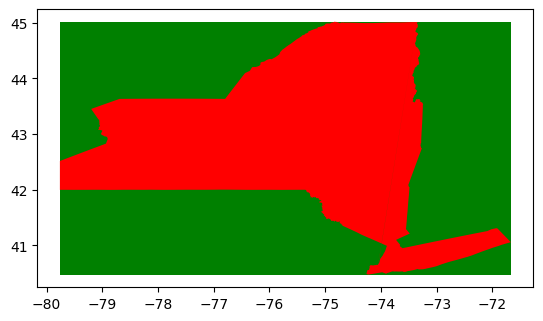

In [3]:
#Get bounding box of New York state, so we know how many neurons to create in the CNN.

# Possible issues --- incorrect labelling/identification, incorrect GPS data, too coarse/fine of location demarcation. Over/Undercounting (eg, counting the same bird twice)

base_name = "State"
if not all([os.path.exists(base_name+"."+ext) for ext in ["shp", "prj", "dbf"]]):
    if not os.path.exists(base_name+".zip"):
        with open(base_name+".zip", "wb") as f:
            f.write(requests.get("https://services6.arcgis.com/EbVsqZ18sv1kVJ3k/arcgis/rest/services/NYS_Civil_Boundaries/FeatureServer/replicafilescache/NYS_Civil_Boundaries_2387526073108640071.zip").content)

    with zipfile.ZipFile(base_name+".zip") as f:
        f.extractall()

import shapefile, pyproj, shapely.geometry, shapely.ops
import geopandas as gpd

with shapefile.Reader("State.shp") as reader:
    fromproj=pyproj.crs.CRS(open("State.prj","r").read())
    toproj=pyproj.crs.CRS(4326)
    transformer=pyproj.Transformer.from_crs(fromproj,toproj,always_xy=True)
    
    state=shapely.ops.transform(transformer.transform, shapely.geometry.Polygon( reader.shape(0).points )) # The first two coordinates are for the bottom left corner of the bounding box, and the last two coordinates are for the top right corner
    bounds=state.bounds
    bounds_box=shapely.geometry.box( *bounds)
    print(f"New York bounds: {bounds}")

state_plot = gpd.GeoDataFrame(geometry=[state])

state_plot.plot(ax= gpd.GeoDataFrame(geometry=[bounds_box]).plot( color="green"), color="red")

In [4]:
import numpy as np
from collections import defaultdict

precision = 0.05 # Truncate locations to 0.05 of a degree 

#IGNORE: (It's likely that the reason it does not converge well because there are not enough neurons. At least I didn't have to worry about overfitting!)

round_down = lambda x: np.floor(x / precision)*precision # From here: https://stackoverflow.com/a/41383821/17920058. However, this function is suspectible to floating-point errors (Using 20 instead of 0.05 would remove these errors. In general, we should use the closest rational number to a string specifying the precision)

# We are rounding (long, lat) pairs to the bottom left corner of each box

int_func = np.frompyfunc(int, 1, 1) # So int can be used with scalars and arrays 

pos = lambda a, b: int_func((round_down(b)-round_down(a))/precision)

x_min, y_min, x_max, y_max = bounds

# We want the upper right bounds to be "pushed outwards"
x_max+=precision
y_max+=precision

x_min=round_down(x_min)
y_min=round_down(y_min)

x_max=round_down(x_max)
y_max=round_down(y_max)

df = df.filter(pl.col(long_col).is_between(x_min, x_max) & pl.col(lat_col).is_between(y_min, y_max))

x_pos = lambda x: pos(x_min, x)

y_pos = lambda y: pos(y_min, y)

x_neurons = x_pos(x_max)
y_neurons = y_pos(y_max)

input_size=x_neurons*y_neurons
position = lambda x,y : x_pos(x) + x_neurons * y_pos(y)
        
bird_map = { row[0]: i for i, row in enumerate(df.select(name_col).unique().iter_rows()) }

X = np.zeros((len(bird_map), y_neurons, x_neurons))
Y = [None]*len(bird_map)


happened = False

with alive_bar(len(df)) as bar:
    for row in df.iter_rows(named=True):
            idx = bird_map[row[name_col]]
        
            lat = y_pos(row[lat_col])
            long = x_pos(row[long_col])

            # Sanity check --- each computed position should be between 0 and input_size
            if not ((0 <= lat < y_neurons) and (0 <= long < x_neurons)):
                print(f"Position for ({row[long_col], row[lat_col]}) is ({long}, {lat}, which is outside the range ({x_neurons}, {y_neurons}).")
            else:
                X[idx][lat][long]+=1
                #import pdb
                #pdb.set_trace()
                Y[idx]=row[habitat_col]
            bar()
        
# Sanity check --- each bird in the map should have at least one observation

with alive_bar(len(bird_map)) as bar:
    for bird, idx in bird_map.items():
        _sum=np.sum(X[idx])
        if _sum==0:
            print(f"Bird {bird} has no observations!")
        else:
            X[idx]/=_sum
        bar()
    

|████████████████████████████████████████| 279777/279777 [100%] in 2.7s (104670.|███████▌                                | ▃▅▇ 52740/279777 [19%] in 1s (~3s, 69|█████████▋                              | ▆█▆ 67188/279777 [24%] in 1s (~3s, 72|███████████████▏                        | ▁▃▅ 105953/279777 [38%] in 1s (~2s, 8|████████████████▊                       | ▄▆█ 117134/279777 [42%] in 1s (~2s, 8|█████████████████████▎                  | ▄▂▂ 148586/279777 [53%] in 2s (~2s, 8
|████████████████████████████████████████| 414/414 [100%] in 0.5s (847.66/s)    


In [5]:
model_name = "model.keras"
history_name = "history.json"
model_exists = os.path.exists(model_name)

In [6]:
# Ah, my "favorite" part --- fiddling with the parameters until it does what I want
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Dense, Dropout, Conv2D, MaxPooling2D, Input, Flatten
from tensorflow.keras import Sequential

tf.keras.backend.clear_session()

lookup=StringLookup(output_mode='one_hot')
lookup.adapt(Y)
Y_new=lookup(Y).numpy()
X_new=X

if not model_exists:
    model = Sequential()

    model.add(Input(shape=(x_neurons, y_neurons, 1)))

    # IGNORE: When a DNN was used, at first a Dense layer of 2**8 units was used --- however, there was heavy fitting, likely because 2**8 ~ (the number of birds in the training set). Therefore, the model possibly just "stored" each bird's map separately in its weight, without having generalized any of the information. 98% training accuracy, but 23% validation accuracy 

    for i in range(5):
        model.add(Conv2D(filters=2**6, kernel_size=3, activation='relu', padding="same"))
        model.add(Dropout(rate=0.2)) #To avoid overfitting
        model.add(MaxPooling2D(padding="same"))
        model.add(Dropout(rate=0.2)) #To avoid overfitting

    model.add(Flatten())
    model.add(Dense(units=2**6, activation='relu'))
    model.add(Dense(units=lookup.vocabulary_size(), activation='softmax')) # Wonder what would happen if I used [ Dense(activation="relu"), Lambda(lambda x : x/sum(x)) ], like I did with the activation maximization model
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
else:
    model = tf.keras.models.load_model(model_name)
    
display(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 164, 92, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 164, 92, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 82, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 82, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 82, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 82, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 41, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 41, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 23, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 41, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 21, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 21, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 6, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 11, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,774 (2.55 MB)

 Trainable params: 222,924 (870.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 445,850 (1.70 MB)

None

In [7]:
from sklearn.model_selection import train_test_split
import json
X_train, X_val, Y_train, Y_val = train_test_split(X_new, Y_new, test_size=0.3, shuffle=True, random_state=0)

if not model_exists:
    history=model.fit(x=X_train, y=Y_train, epochs=100, validation_data=(X_val, Y_val))

    model.save(model_name)
    json.dump(history.history, open(history_name, "w+"))

    model_exists = True
    

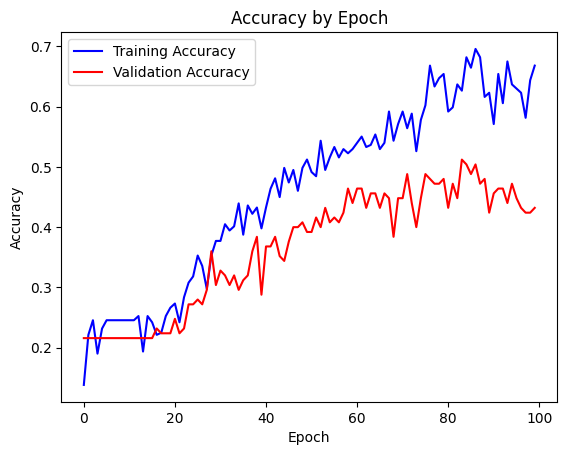

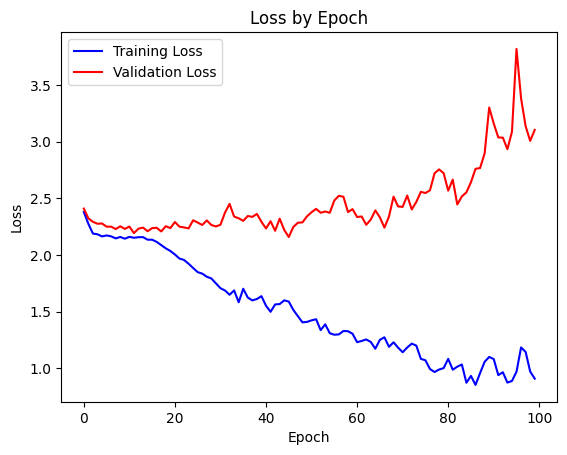

In [21]:
import matplotlib.pyplot as plt

if not model_exists:
    history_dict = history.history
else:
    history_dict = json.load(open(history_name, "r"))

for score in ["accuracy", "loss"]:
    plt.figure()
    plt.title(f'{score.title()} by Epoch')
    plt.plot(history_dict[score], label=f'Training {score.title()}',color='blue')
    plt.plot(history_dict[f'val_{score}'], label = f'Validation {score.title()}',color='red')
    plt.xlabel('Epoch')
    plt.ylabel(score.title())
    plt.legend()

In [10]:
def score(X):
    return model.evaluate(X, Y_val, verbose=0, return_dict=True)["accuracy"]
    
x_iter = np.linspace(x_min, x_max, num=x_neurons, endpoint=False)
y_iter = np.linspace(y_min, y_max, num=y_neurons, endpoint=False)

In [12]:
# Permutation importance --- determine relative importance of features by shuffling different features 

"""
I could have just made the feature 0, but that would have changed the mean and variance of the feature.

I could have sampled from a normal Guassian distribution with the same mean and variance, but permuting is faster.
"""
# While writing this up, I realize that there is a small floating-point error that caused the code to create more subdivisions than was strictly neccessary. Since this doesn't actually affect the model much, to avoid retraining the model, and the fact that it was considered subjectively "cleaner" to deal with the precision directly instead of its inverse, the "buggy" code was kept in

import numpy as np
import copy

scores = np.zeros((y_neurons, x_neurons))
X_permute=np.zeros((len(X_val), y_neurons, x_neurons))

repetitions = 10

reference_score = score(X_val)
with alive_bar(input_size*repetitions) as bar:
    for x in x_iter:
        for y in y_iter:
            x1=x_pos(x)
            y1=y_pos(y)
            np.copyto(X_permute, X_val)
            for i in range(repetitions):
                np.random.default_rng(seed=i).shuffle(X_permute[:, y1, x1])     

                scores[y1, x1]+=score(X_permute)
                
                #scores[y1, x1] += np.sum(np.argmax(model.predict(X_permute, verbose=0), axis=1) == np.argmax(Y_val, axis=1)) #Evaluate is too slow to operate on a single batch, so I combine them all into one set so I can evaluate them all at once.
                
                bar()

scores/=repetitions # Mean of the accuracy across all repetitions

#scores/=(len(X_val)*repetitions) # Mean of the accuracy across all repetitions

scores=np.abs(reference_score - scores) #The larger it is, the more important the feature is

|⚠︎                                       | (!) 21/15088 [0%] in 1:05.5 (0.32/s) 


KeyboardInterrupt: 

In [11]:
shapes = []

with alive_bar(input_size) as bar:
    for x in x_iter:
        for y in y_iter:
            shapes.append(shapely.geometry.box(x,y,x+precision, y+precision))

            bar()

|████████████████████████████████████████| 15088/15088 [100%] in 0.2s (64880.14/


In [13]:
# NOTE: Make state_plot have thick black border and is clear
def scores_plot(scores, title):
    display(state_plot.boundary.plot(ax=gpd.GeoDataFrame(data={"geometry": shapes, "importance": scores}).plot(column="importance", legend=True, legend_kwds={"label": title, "orientation": "horizontal"}), edgecolor="black"))


In [ ]:
scores_plot(scores.flatten(), title="Permute Importance")

In [15]:
lookup.get_vocabulary()

['[UNK]',
 np.str_('Forests'),
 np.str_('Open Woodlands'),
 np.str_('Marshes'),
 np.str_('Lakes and Ponds'),
 np.str_('Grasslands'),
 np.str_('Shorelines'),
 np.str_('Oceans'),
 np.str_('Scrub'),
 np.str_('Tundra'),
 np.str_('Towns'),
 np.str_('Rivers and Streams')]

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 15088)          │        30,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 164, 92, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 12)             │       222,924 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,100 (988.67 KB)

 Trainable params: 30,176 (117.88 KB)

 Non-trainable params: 222,924 (870.80 KB)

None
Loss is now 0.003945781383663416 |████████████████████████████████████████| 1000Loss is now 0.8548225164413452 |███▉                                    | ▄▂▂ 98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Maximizing the input layer for class Open Woodlands gives an output probability distribution of [[0.   0.01 0.99 0.   0.01 0.   0.   0.   0.   0.   0.   0.  ]], compared to [[0 0 1 0 0 0 0 0 0 0 0 0]]
1.0


<Axes: >

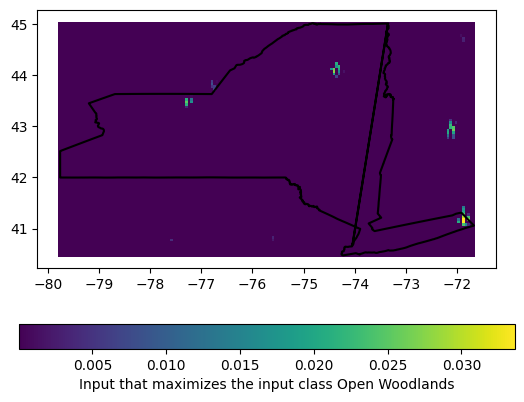

In [19]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Reshape, Lambda

def ActivationMaximization(habitat):
    shape=tuple(filter(None, model.input_shape)) # Remove None from shape
    units = np.prod(shape)


    def custom_activation(x):
        x=tf.abs(x)

        return x/tf.reduce_sum(x)

        
    m = Sequential([Dense(units=np.prod(shape), use_bias=True, input_shape=(1,), activation=custom_activation), Reshape(target_shape=shape), model])

    m.layers[2].trainable=False
    
    m.compile(optimizer="adam", loss="categorical_crossentropy")

    print(m.summary())
    x=np.ones((1,1))
    
    y=lookup(habitat)

    epochs = 1000 #We want this model to REALLY overfit
    with alive_bar(epochs) as bar:
        def callback(_, logs):
            bar()
            bar.title(f"Loss is now {logs['loss']}")
            
        m.fit(x=x, y=y, epochs=epochs, verbose=0, shuffle=False, callbacks=tf.keras.callbacks.LambdaCallback(on_epoch_end=callback))

    output = m.predict(x)

    with np.printoptions(precision=2, suppress=True):
        print(f"Maximizing the input layer for class {habitat} gives an output probability distribution of {output}, compared to {y}")

    output = m.layers[0](x).numpy()

    print(np.sum(output))
    scores_plot(output[0], f"Input that maximizes the input class {habitat}")

ActivationMaximization("Open Woodlands")